## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('price_optimization_data.csv')

In [3]:
df = df.rename(columns={'Category' : 'category'})

## Exploratory Data Analysis (EDA)

I want to start by examining the data, understanding at least at a basic level if there are any patterns worth noting at the category and price levels.

In [4]:
df_eda = df.copy()

In [5]:
# Calculating daily profit and seeing what works and what doesn't
df_eda['daily_profit'] = (df_eda['price'] - df_eda['cost']) * df_eda['orders']

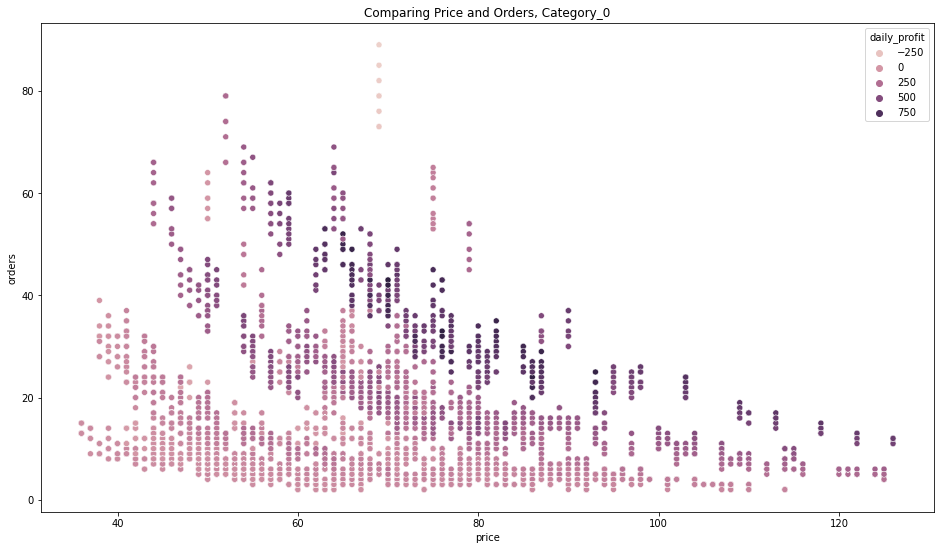

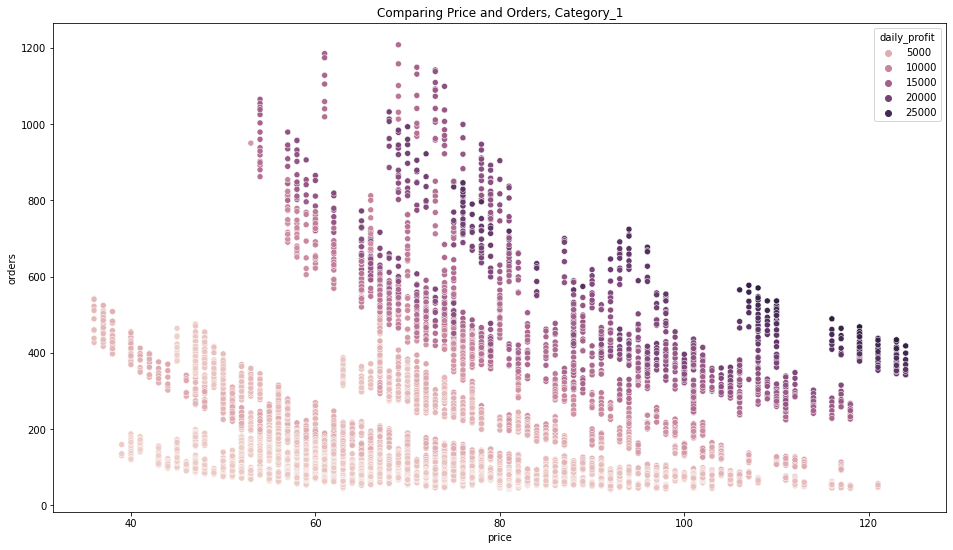

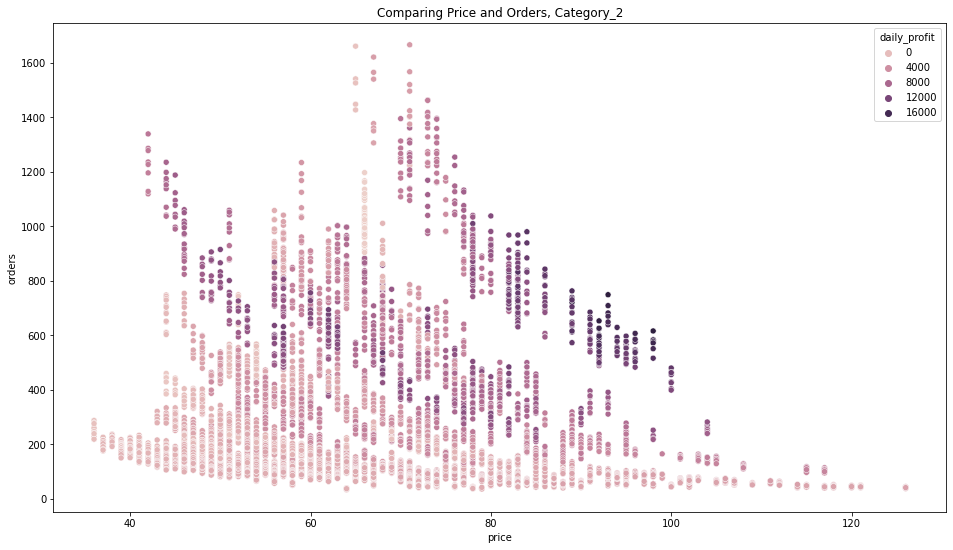

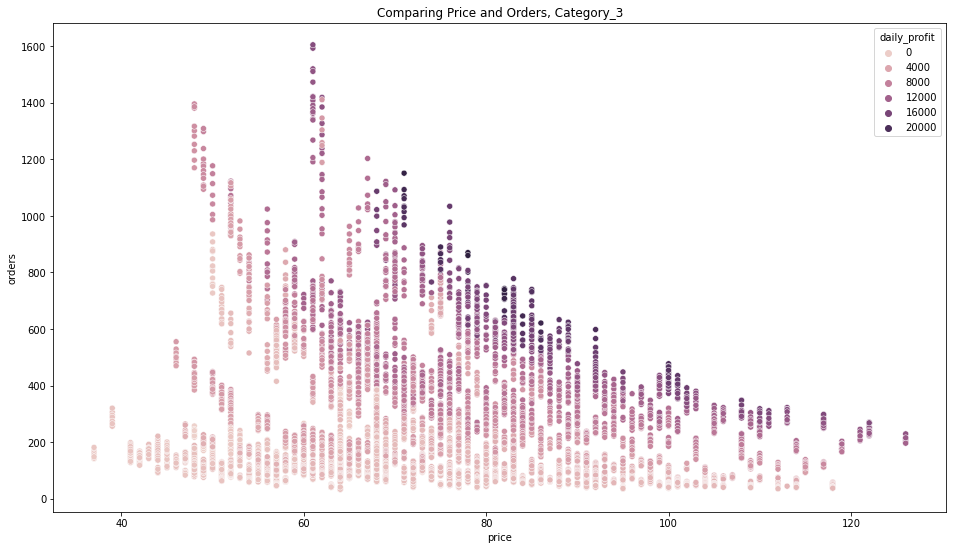

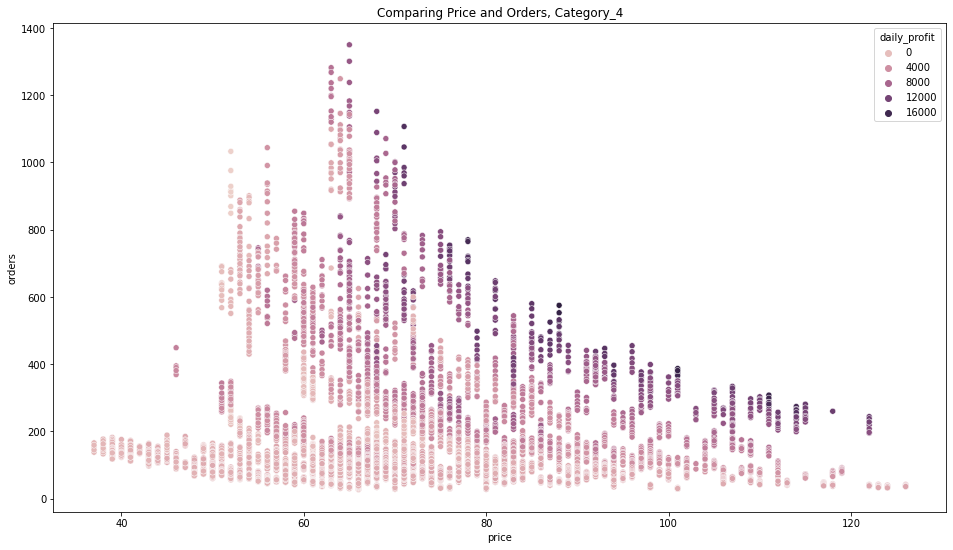

In [6]:
for x in range(5):
    plt.figure(figsize=(16, 9))
    plt.title(f'Comparing Price and Orders, Category_{x}')
    sns.scatterplot(data=df_eda[df_eda['category'] == f'Category_{x}'], x='price', y='orders', hue='daily_profit')
    plt.show();

For every product category, we tend to see similar yet different patters of price and order behavior. Ideally, the strategy to reach maximum profitability based on these visualizations would be to figure out a way to price all of our products near the top and darkest points on these charts based on predicted orders for any given day.

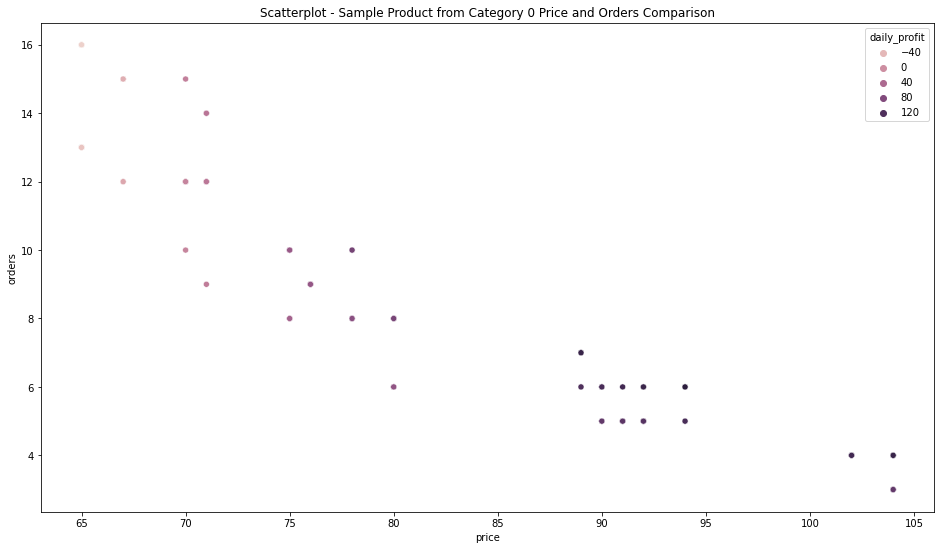

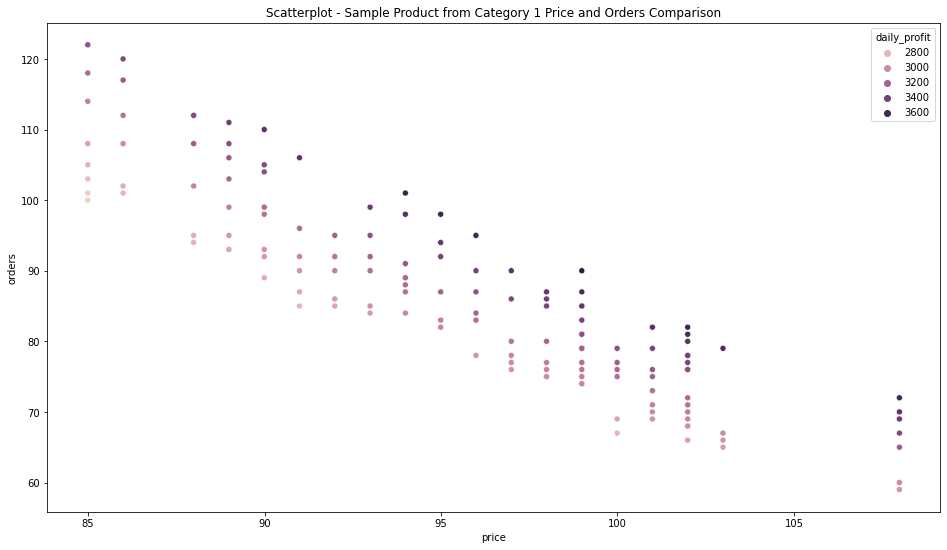

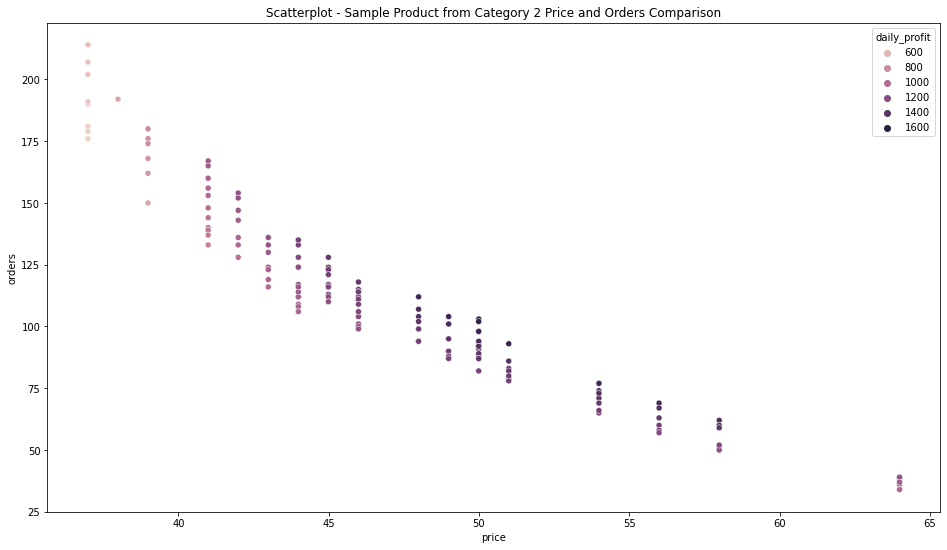

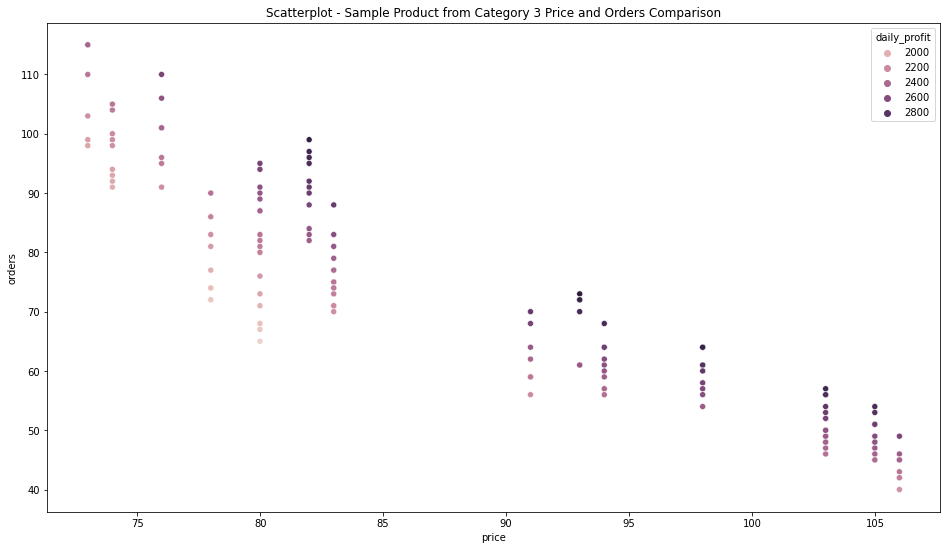

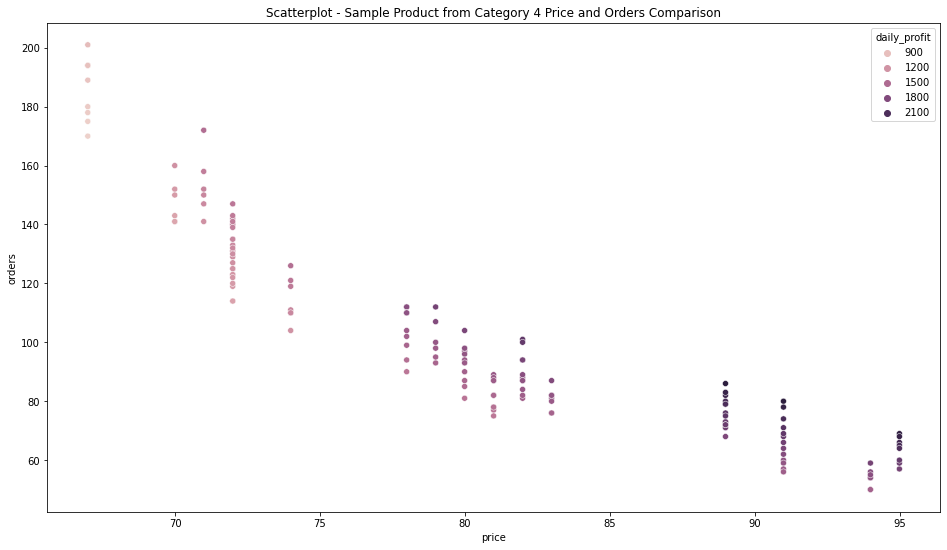

In [7]:
# Taking 1 product from each category and examining the price/order behavior for each product
df_eda['product'] = df_eda['product'].replace('Product_0_9', 'Product_0_09') # changing format to be able to include in the for loop with other similarly formatted sample products

for x in range(5):
    plt.figure(figsize=(16, 9))
    plt.title(f'Scatterplot - Sample Product from Category {x} Price and Orders Comparison')
    sns.scatterplot(data=df_eda[df_eda['product'] == f'Product_{x}_{x}9'], x='price', y='orders', hue='daily_profit')
    plt.show();

We see similar behavior at the product level that we do at the category level. We also see clusters of points, indicating price bands. High daily profit levels tend to be either near the median or near the maximum of the price range. Unsurprisingly, we see curves indicating a negative relationship between price and orders. However, this relationship differs by product. Thus an analysis to impute the nulls on the 150th day and to find the optimal price would not be possible or accurate at the category level- it must be done on the product level.

## Testing strategies to solve the problem - Price Elasticity

The methodology here is to:
1. Calculate price elasticity at the product level for each difference in price
2. Calculate the mean elasticity, and use it as a "slope" to generalize and predict orders at different price points
3. Use predicted orders to calculate predicted daily profit
4. Find the price and predicted orders at max daily predicted profit.
5. Impute price and predicted orders into the original dataframe.

In [8]:
# Creating a dataframe for a single product so I can test transformations that I would use in the production-ready function.
product_0_df = df_eda[df_eda['product'] == 'Product_0_09']

In [9]:
product_0_df

,day,category,product,price,cost,reviews,ship_speed,orders,daily_profit
1350,0,Category_0,Product_0_09,91.99,69.02,2339.0,9,5.0,114.85
1351,1,Category_0,Product_0_09,91.99,69.02,2339.0,9,5.0,114.85
1352,2,Category_0,Product_0_09,91.99,69.02,2339.0,9,5.0,114.85
1353,3,Category_0,Product_0_09,91.99,69.02,2339.0,9,5.0,114.85
1354,4,Category_0,Product_0_09,91.99,69.02,2339.0,9,5.0,114.85
...,...,...,...,...,...,...,...,...,...
1495,145,Category_0,Product_0_09,64.99,69.02,2339.0,9,13.0,-52.39
1496,146,Category_0,Product_0_09,64.99,69.02,2339.0,9,13.0,-52.39
1497,147,Category_0,Product_0_09,64.99,69.02,2339.0,9,13.0,-52.39
1498,148,Category_0,Product_0_09,64.99,69.02,2339.0,9,16.0,-64.48


In [10]:
# Finding average cost and orders by each price point
avg_orders_price_df = pd.DataFrame(product_0_df.groupby('price')[['orders', 'cost']].mean()).reset_index()

In [11]:
avg_orders_price_df = avg_orders_price_df.rename(columns={'orders' : 'avg_orders', 'cost' : 'avg_cost'})

In [12]:
# Calculating the percentage change in price and orders to calculate elasticity
diff_df = avg_orders_price_df.drop(columns=['avg_cost'])
diff_df = diff_df.pct_change()

In [13]:
diff_df = diff_df.rename(columns={'price' : 'price_diff', 'avg_orders' : 'order_diff'})

In [14]:
diff_df['elasticity'] = diff_df['order_diff'] / diff_df['price_diff']

In [15]:
diff_df

,price_diff,order_diff,elasticity
0,NaN,NaN,NaN
1,0.030774,-0.017928,-0.582580
2,0.044783,-0.164751,-3.678889
3,0.014288,0.001147,0.080264
4,0.056346,-0.216495,-3.842242
5,0.013335,-0.052632,-3.946842
6,0.026319,-0.061728,-2.345370
7,0.025644,-0.187970,-7.329887
8,0.112514,-0.015625,-0.138872
9,0.011237,-0.185185,-16.479630


In [16]:
# Merging the two dataframes. Not optimal. Will likely change this step in the final function.
orders_and_diff_df = avg_orders_price_df.join(diff_df)

In [17]:
# Need to scale elasticity to the price_diff column because each row of price differences do not necessarily equate to a 1% difference.
orders_and_diff_df['loss_of_orders_generalized_elasticity'] = orders_and_diff_df['price_diff'] * -3.5180548715204254
orders_and_diff_df

,price,avg_orders,avg_cost,price_diff,order_diff,elasticity,loss_of_orders_generalized_elasticity
0,64.99,14.764706,69.02,NaN,NaN,NaN,NaN
1,66.99,14.500000,69.02,0.030774,-0.017928,-0.582580,-0.108264
2,69.99,12.111111,69.02,0.044783,-0.164751,-3.678889,-0.157548
3,70.99,12.125000,69.02,0.014288,0.001147,0.080264,-0.050265
4,74.99,9.500000,69.02,0.056346,-0.216495,-3.842242,-0.198228
5,75.99,9.000000,69.02,0.013335,-0.052632,-3.946842,-0.046914
6,77.99,8.444444,69.02,0.026319,-0.061728,-2.345370,-0.092593
7,79.99,6.857143,69.02,0.025644,-0.187970,-7.329887,-0.090218
8,88.99,6.750000,69.02,0.112514,-0.015625,-0.138872,-0.395831
9,89.99,5.500000,69.02,0.011237,-0.185185,-16.479630,-0.039533


In [18]:
# Shifting up to match rows and calculate with avg_orders
orders_and_diff_df['loss_of_orders_generalized_elasticity'] = orders_and_diff_df['loss_of_orders_generalized_elasticity'].shift(-1)

In [19]:
orders_and_diff_df

,price,avg_orders,avg_cost,price_diff,order_diff,elasticity,loss_of_orders_generalized_elasticity
0,64.99,14.764706,69.02,NaN,NaN,NaN,-0.108264
1,66.99,14.500000,69.02,0.030774,-0.017928,-0.582580,-0.157548
2,69.99,12.111111,69.02,0.044783,-0.164751,-3.678889,-0.050265
3,70.99,12.125000,69.02,0.014288,0.001147,0.080264,-0.198228
4,74.99,9.500000,69.02,0.056346,-0.216495,-3.842242,-0.046914
5,75.99,9.000000,69.02,0.013335,-0.052632,-3.946842,-0.092593
6,77.99,8.444444,69.02,0.026319,-0.061728,-2.345370,-0.090218
7,79.99,6.857143,69.02,0.025644,-0.187970,-7.329887,-0.395831
8,88.99,6.750000,69.02,0.112514,-0.015625,-0.138872,-0.039533
9,89.99,5.500000,69.02,0.011237,-0.185185,-16.479630,-0.039094


In [20]:
orders_and_diff_df['order_pred'] = (orders_and_diff_df['avg_orders'] * orders_and_diff_df['loss_of_orders_generalized_elasticity']) + orders_and_diff_df['avg_orders']

In [21]:
# Shifting order prediction back down
orders_and_diff_df['order_pred'] = orders_and_diff_df['order_pred'].shift(1)

In [22]:
# Making the assumption that the lowest price point is similar to what the elasticity model would predict.
orders_and_diff_df['order_pred'][0] = orders_and_diff_df['avg_orders'][0]
orders_and_diff_df

,price,avg_orders,avg_cost,price_diff,order_diff,elasticity,loss_of_orders_generalized_elasticity,order_pred
0,64.99,14.764706,69.02,NaN,NaN,NaN,-0.108264,14.764706
1,66.99,14.500000,69.02,0.030774,-0.017928,-0.582580,-0.157548,13.166212
2,69.99,12.111111,69.02,0.044783,-0.164751,-3.678889,-0.050265,12.215549
3,70.99,12.125000,69.02,0.014288,0.001147,0.080264,-0.198228,11.502345
4,74.99,9.500000,69.02,0.056346,-0.216495,-3.842242,-0.046914,9.721483
5,75.99,9.000000,69.02,0.013335,-0.052632,-3.946842,-0.092593,9.054320
6,77.99,8.444444,69.02,0.026319,-0.061728,-2.345370,-0.090218,8.166667
7,79.99,6.857143,69.02,0.025644,-0.187970,-7.329887,-0.395831,7.682603
8,88.99,6.750000,69.02,0.112514,-0.015625,-0.138872,-0.039533,4.142876
9,89.99,5.500000,69.02,0.011237,-0.185185,-16.479630,-0.039094,6.483151


In [23]:
orders_and_diff_df['profit_pred'] = (orders_and_diff_df['price'] - orders_and_diff_df['avg_cost']) * orders_and_diff_df['order_pred']

In [24]:
# Testing elasticity value
diff_df['elasticity'].mean()

-3.5180548715204254

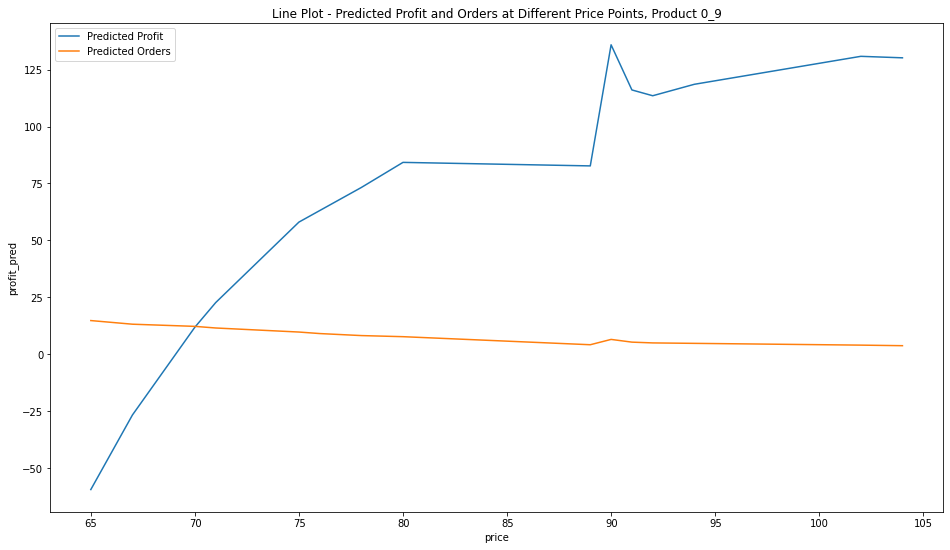

In [27]:
plt.figure(figsize=(16, 9))
plt.title('Line Plot - Predicted Profit and Orders at Different Price Points, Product 0_9')
sns.lineplot(data=orders_and_diff_df, x='price', y='profit_pred', label='Predicted Profit')
sns.lineplot(data=orders_and_diff_df, x='price', y='order_pred', label='Predicted Orders');

Optimal price point is where estimated profit here peaks. Predicted orders is where on the orders line (predicted by elasticity) correlates to that price point.

## Final function, Production ready

In [26]:
def price_opt_func(df):
    """Returns a dataframe with the 150th row nulls for each product filled in with predicted order values and optimized price values."""
    
    # initialize empty dataframe
    df_output = pd.DataFrame()

    # For loop to separate each product and find elasticity on the product level
    for x in df['product'].unique():
        
        # separates products and makes copy of df
        df_product = df[df['product'] == x]
        df_product = df_product.copy()
        
        # Creates a new groupby df to find average orders and cost by price
        df_g = pd.DataFrame(df_product.groupby('price')[['orders', 'cost']].mean()).reset_index()

        # Calculates percentage change of price and orders to calculate elasticity for each price difference
        df_g['price_diff_pct'] = df_g['price'].pct_change()
        df_g['order_diff_pct'] = df_g['orders'].pct_change()
        df_g['elasticity'] = df_g['order_diff_pct'] / df_g['price_diff_pct']
        elasticity = df_g['elasticity'].mean()

        # Find predicted order loss. Doing it this way because elasticity is measured on a percentage basis (1% increase in price == x% decrease in orders). 
        # However, the price changes in the data may not necessarily change in increments of 1%. 
        # Thus, elasticity must be scaled to the price changes in the data. (pred_order_loss)
        df_g['pred_order_loss'] = df_g['price_diff_pct'] * elasticity
        # Shifting up to calculate with average orders
        df_g['pred_order_loss'] = df_g['pred_order_loss'].shift(-1)

        # Making order predictions
        df_g['order_pred'] = (df_g['orders'] * df_g['pred_order_loss']) + df_g['orders']
        # Shifting down since pred_order_loss was shifted up previously
        df_g['order_pred'] = df_g['order_pred'].shift(1)
        df_g['pred_order_loss'] = df_g['pred_order_loss'].shift(1)
        # Replacing index 0 value in order_pred with orders.
        # This makes the assumption that, at the lowest price point, the elasticity model would accurately represent real orders.
        df_g['order_pred'][0] = df_g['orders'][0]

        # Predicted profit to find maximum/optimal
        df_g['profit_pred'] = (df_g['price'] - df_g['cost']) * df_g['order_pred']

        # Singling out the row at which profit is maximized
        max_profit_pred_row = df_g[df_g['profit_pred'] == df_g['profit_pred'].max()].reset_index()

        # Optimal price and day order predictions (values to be imputed)
        opt_price = max_profit_pred_row['price'][0]
        day_order_pred = max_profit_pred_row['order_pred'][0]

        # Imputation of values
        df_product['price'] = df_product['price'].fillna(opt_price)
        df_product['orders'] = df_product['orders'].fillna(day_order_pred)

        # Putting the dataframe back together
        df_output = pd.concat([df_output, df_product])
        
    return df_output

price_opt_func(df)

,day,category,product,price,cost,reviews,ship_speed,orders
0,0,Category_0,Product_0_0,51.99,35.14,1601.0,10,5.000000
1,1,Category_0,Product_0_0,51.99,35.14,1601.0,10,5.000000
2,2,Category_0,Product_0_0,51.99,35.14,1601.0,10,5.000000
3,3,Category_0,Product_0_0,51.99,35.14,1601.0,10,5.000000
4,4,Category_0,Product_0_0,51.99,35.14,1601.0,10,5.000000
...,...,...,...,...,...,...,...,...
37495,145,Category_4,Product_4_49,70.99,62.41,1846.0,4,150.000000
37496,146,Category_4,Product_4_49,70.99,62.41,1849.0,4,141.000000
37497,147,Category_4,Product_4_49,70.99,62.41,1852.0,4,147.000000
37498,148,Category_4,Product_4_49,70.99,62.41,1855.0,4,172.000000
